# Crush Rig Lab
Written by Matt MacDonald for CIGITI at the Hospital for Sick Children Toronto
***

All tools to manipulate data will be obtained from the crush_plot.py file.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook
# import matplotlib as mpl
# mpl.rcParams['savefig.dpi'] = 120
# mpl.rcParams['figure.dpi'] = 120

In [3]:
from crush_plot import *

The crush data must be collected using the crush rig and crush.py and stored in the expected folder structure at the root directory indicated by PATH.

In [4]:
PATH = Path('/Users/mattmacdonald/Data/RAWDATA_CRUSH/')

Load all data and modify as needed.

In [5]:
study = study_outline(PATH)
crushes = study_data(study)
crushes = modify(crushes)

In [6]:
study

,Patient Code,Procedure Date,Gender,DOB,Age,Procedure,Tissue,Surgeon,Notes,Issues,Histology,Classification,Folder Name
Test ID,,,,,,,,,,,,,
1,PC1,2018-11-12,M,1943-02-24,27655 days,Anterior resection (laparoscopic) - laparoscop...,sigmoid colon,Vanessa Palter,"Excellent sample, not stored in formalin, obta...","Large tumor, had to take away from margin",SCANNED,COLON,20181112 - PC1 - COLON
2,PC2,2018-11-13,M,1974-01-17,16371 days,"Colectomy left (low anterior resection, loop i...",sigmoid colon,Marcus Burnstein,"sample had tumor, taken well away from margins",inflammed,SCANNED,COLON,20181113 - PC2 - COLON
3,PC3,2018-11-14,M,1964-05-22,19899 days,Sigmoid resection laparoscopic (lap. Sigmoid r...,sigmoid colon,Sandra de Montbrun,great looking sample,"some slippage of tissue at 800, 1000, started ...",SCANNED,COLON,20181114 - PC3 - COLON
4,PC4,2018-11-16,F,1950-12-28,24795 days,"Colectomy Right Hemi / Ileocolic (open, right ...",small bowel attached to right colon,Sandro Rizoli,"able to do stop and multi stop, dx abdominal p...","multi hold 1000 needed to be done twice, first...",SCANNED,SB,20181116 - PC4 - SB
5,PC5,2018-11-20,M,1986-07-15,11816 days,Ileoanal reservoir + loop ileostomy (anal anas...,small bowel and large colon sample,Marcus Burnstein,"very small small bowel sample, was attached to...","slippage of tissue at 200, 800",SCANNED,SB,20181120 - PC5 - SB
6,PC6,2018-11-21,M,1948-07-23,25688 days,Abdominal perineal resection / proctectomy / p...,large colon,Sandra de Montbrun,N/A,N/A,Waiting,COLON,20181121 - PC6 - COLON
7,PC7,2018-11-27,F,1953-01-17,24055 days,Ileostomy and rectum,Rectum,Marcus Burnstein,thickened samples,Ulcerative colitis,Waiting,COLON,20181127 - PC7 - COLON
8,PC8,2018-11-28,F,1961-10-18,20860 days,right hemicolectomy,colon,Sandra de Montbrun,"last 2 cecum, first 4 ascending colon",ascending colon carcinoma,Waiting,COLON,20181128 - PC8 - COLON
9,PC9,2018-11-28,M,1927-05-25,33425 days,hemicolectomy right,colon,Nancy Baxter,N/A,A-F colon,Waiting,COLON,20181128 - PC9 - COLON


In [7]:
crushes

,Test ID,Datetime,Patient,Tissue,Protocol,Load,Target,Data,Summary
Crush,,,,,,,,,
0,1,2018-11-12 19:01:30,PC1,COLON,stop,1000g,9.810,Position (mm) Velocity (mm/s...,"Patient PC1 (COLON), stop crush at 1000g"
1,1,2018-11-12 18:57:08,PC1,COLON,stop,600g,5.886,Position (mm) Velocity (mm/s...,"Patient PC1 (COLON), stop crush at 600g"
2,1,2018-11-12 18:59:38,PC1,COLON,stop,800g,7.848,Position (mm) Velocity (mm/s...,"Patient PC1 (COLON), stop crush at 800g"
3,1,2018-11-12 18:53:10,PC1,COLON,stop,200g,1.962,Position (mm) Velocity (mm/s...,"Patient PC1 (COLON), stop crush at 200g"
4,1,2018-11-12 18:55:24,PC1,COLON,stop,400g,3.924,Position (mm) Velocity (mm/s...,"Patient PC1 (COLON), stop crush at 400g"
5,1,2018-11-12 19:03:12,PC1,COLON,stop,1200g,11.772,Position (mm) Velocity (mm/s...,"Patient PC1 (COLON), stop crush at 1200g"
6,2,2018-11-13 19:26:44,PC2,COLON,stop,1000g,9.810,Position (mm) Velocity (mm/s...,"Patient PC2 (COLON), stop crush at 1000g"
7,2,2018-11-13 19:24:28,PC2,COLON,stop,600g,5.886,Position (mm) Velocity (mm/s...,"Patient PC2 (COLON), stop crush at 600g"
8,2,2018-11-13 19:25:38,PC2,COLON,stop,800g,7.848,Position (mm) Velocity (mm/s...,"Patient PC2 (COLON), stop crush at 800g"


Time series plots can be made with time_plot(crushes) and stress-strain plots can be made with stress_plot(crushes).

<IPython.core.display.Javascript object>


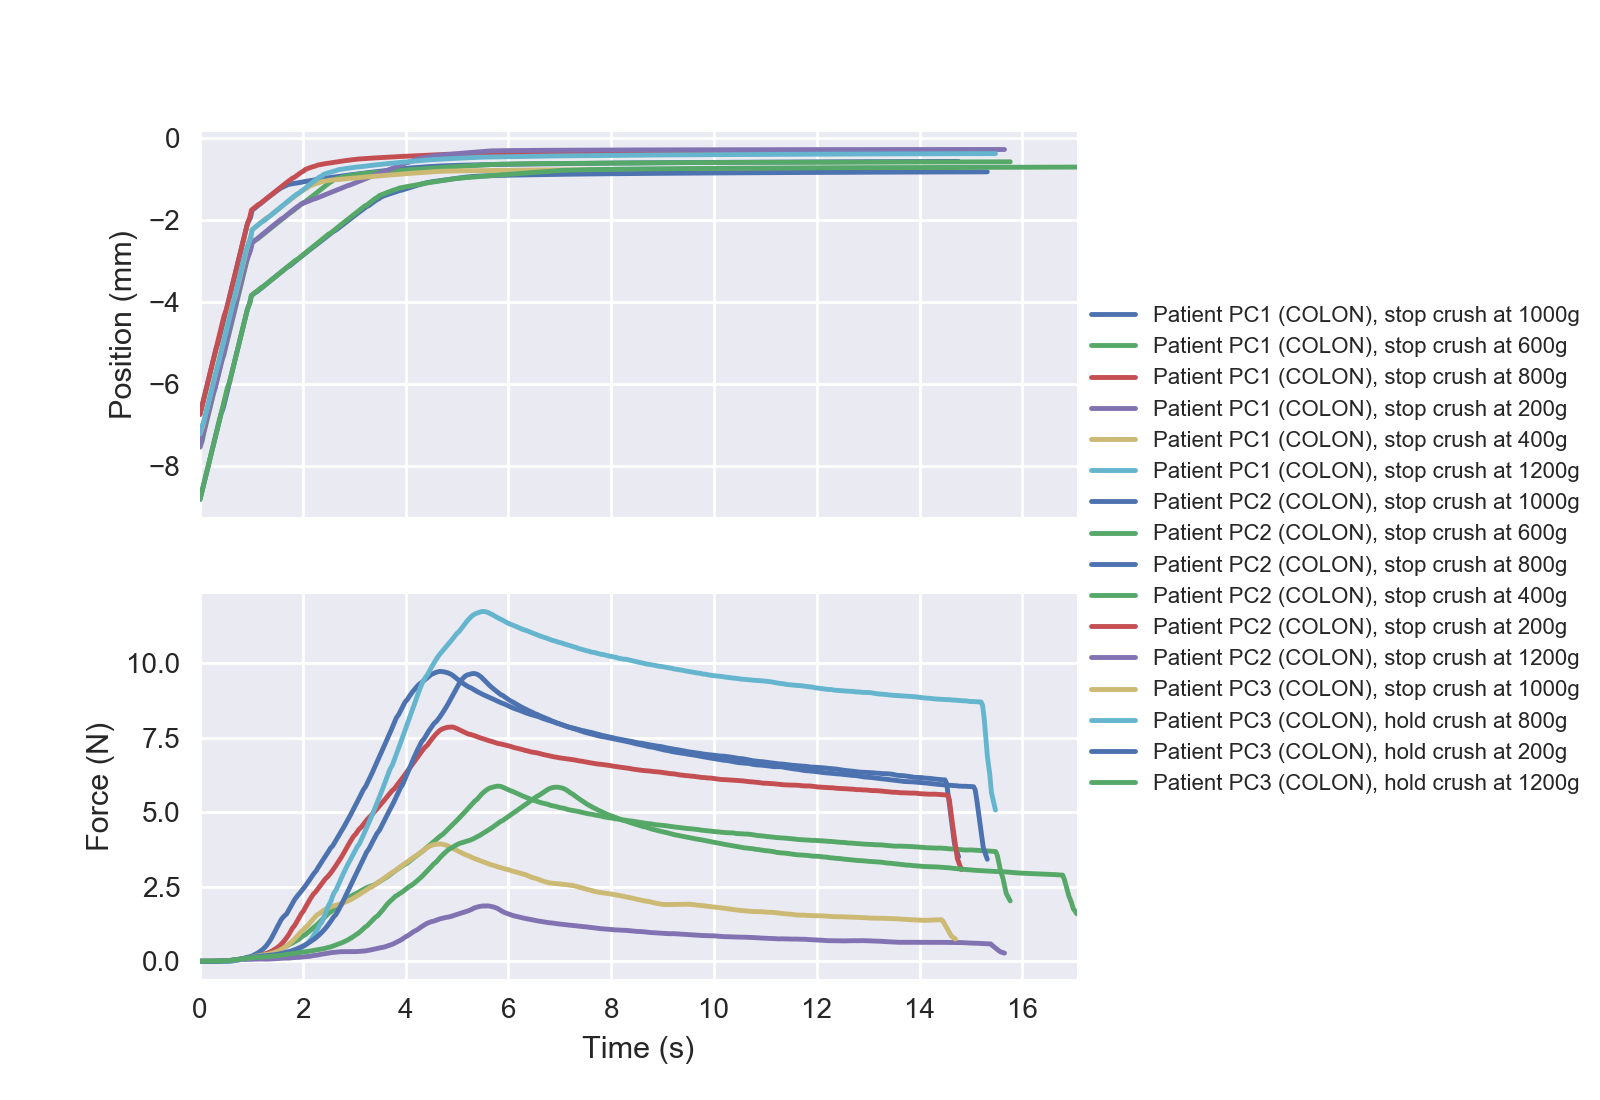

In [8]:
time_plot(crushes)

<IPython.core.display.Javascript object>


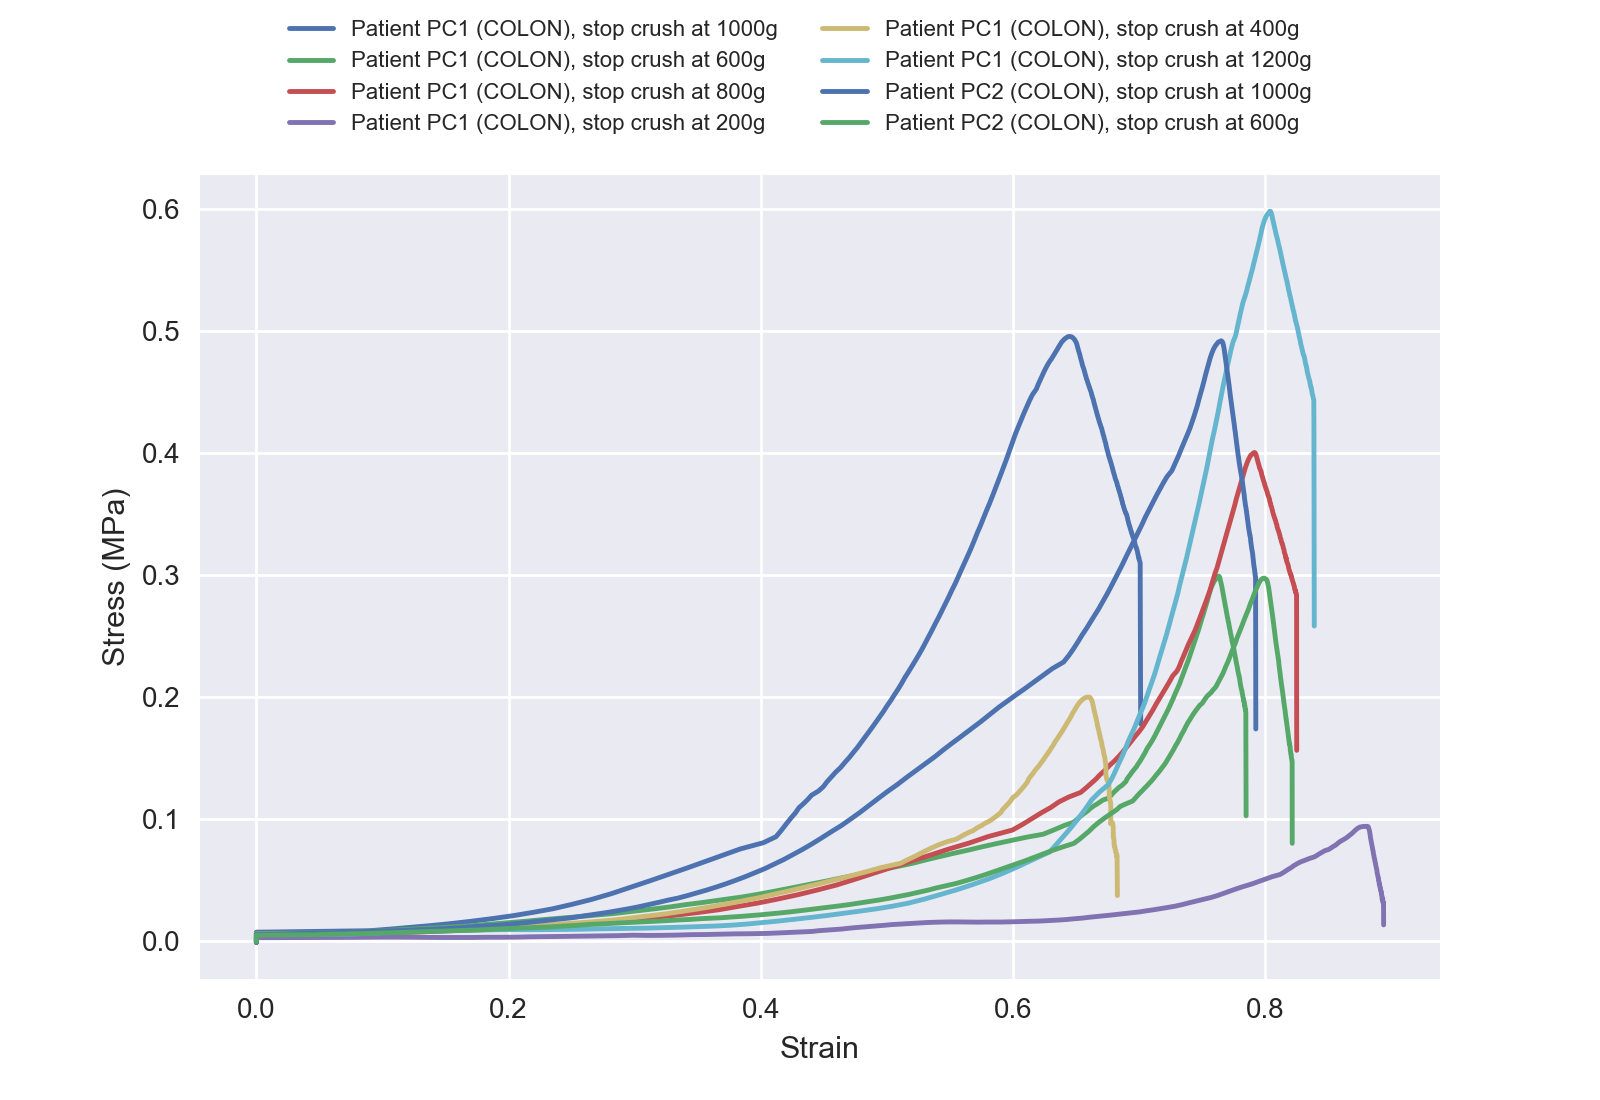

In [9]:
stress_plot(crushes)

Select subsets of the crushes using the convenience functions:
- patient(*patient*)
- tissue(*tissue*)
- protocol(*protocol*)
- load(*load*)

In [10]:
# Convenience functions
def patient(patient):
    return crushes.loc[crushes['Patient'] == patient.upper(), :]

def tissue(tissue):
    return crushes.loc[crushes['Tissue'] == tissue.upper(), :]

def protocol(protocol):
    return crushes.loc[crushes['Protocol'] == protocol.lower(), :]

def load(load):
    return crushes.loc[crushes['Load'] == load.lower(), :]

Subsets can be combined using select( ).

In [27]:
def select(*args, **kwargs):
    args = list(args)
    for key, val in kwargs.items():
        args.append(globals()[key](val))
    if len(args) == 1:
        return args[0]
    if len(args) > 2:
        args = [args[0], select(*args[1:])]
    index = (args[0].index).intersection(args[1].index)
    return crushes.loc[index, :]

In [12]:
protocol('hold')

,Test ID,Datetime,Patient,Tissue,Protocol,Load,Target,Data,Summary
Crush,,,,,,,,,
13,3,2018-11-14 19:42:18,PC3,COLON,hold,800g,7.848,Position (mm) Velocity (mm/s...,"Patient PC3 (COLON), hold crush at 800g"
14,3,2018-11-14 19:36:24,PC3,COLON,hold,200g,1.962,Position (mm) Velocity (mm/s...,"Patient PC3 (COLON), hold crush at 200g"
15,3,2018-11-14 19:45:28,PC3,COLON,hold,1200g,11.772,Position (mm) Velocity (mm/s...,"Patient PC3 (COLON), hold crush at 1200g"
18,3,2018-11-14 19:39:32,PC3,COLON,hold,400g,3.924,Position (mm) Velocity (mm/s...,"Patient PC3 (COLON), hold crush at 400g"
20,3,2018-11-14 19:43:42,PC3,COLON,hold,1000g,9.810,Position (mm) Velocity (mm/s...,"Patient PC3 (COLON), hold crush at 1000g"
25,3,2018-11-14 19:41:00,PC3,COLON,hold,600g,5.886,Position (mm) Velocity (mm/s...,"Patient PC3 (COLON), hold crush at 600g"


In [13]:
select(patient('pc3'), protocol('hold'), load('1200g'))

,Test ID,Datetime,Patient,Tissue,Protocol,Load,Target,Data,Summary
Crush,,,,,,,,,
15,3,2018-11-14 19:45:28,PC3,COLON,hold,1200g,11.772,Position (mm) Velocity (mm/s...,"Patient PC3 (COLON), hold crush at 1200g"


In [14]:
x = select(tissue('sb'), load('200g'))
x

,Test ID,Datetime,Patient,Tissue,Protocol,Load,Target,Data,Summary
Crush,,,,,,,,,
31,4,2018-11-16 19:49:26,PC4,SB,multi_stop,200g,1.962,Position (mm) Velocity (mm/s...,"Patient PC4 (SB), multi_stop crush at 200g"
37,4,2018-11-16 19:35:44,PC4,SB,stop,200g,1.962,Position (mm) Velocity (mm/s...,"Patient PC4 (SB), stop crush at 200g"
47,5,2018-11-20 17:13:02,PC5,SB,stop,200g,1.962,Position (mm) Velocity (mm/s...,"Patient PC5 (SB), stop crush at 200g"
48,5,2018-11-20 17:10:44,PC5,SB,stop,200g,1.962,Position (mm) Velocity (mm/s...,"Patient PC5 (SB), stop crush at 200g"
50,5,2018-11-20 17:11:48,PC5,SB,stop,200g,1.962,Position (mm) Velocity (mm/s...,"Patient PC5 (SB), stop crush at 200g"
78,10,2018-11-28 19:18:44,PC9,SB,multi_hold,200g,1.962,Position (mm) Velocity (mm/s...,"Patient PC9 (SB), multi_hold crush at 200g"


<IPython.core.display.Javascript object>


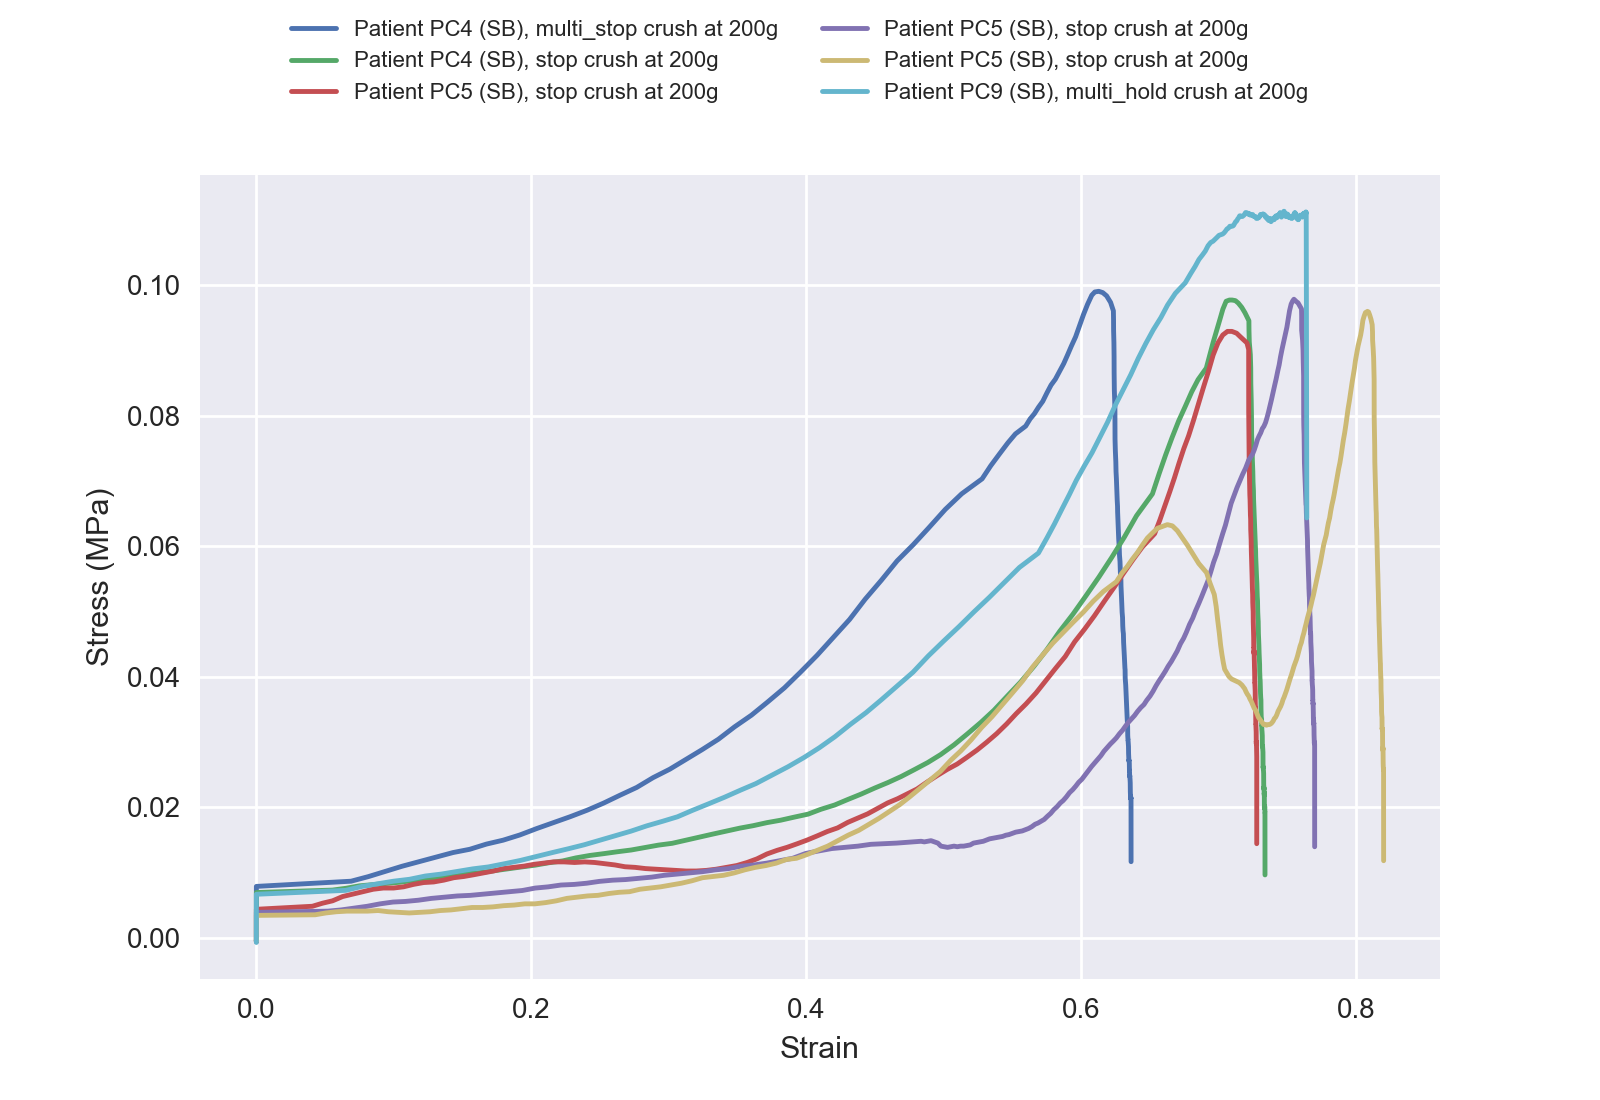

In [15]:
stress_plot(x)

<IPython.core.display.Javascript object>


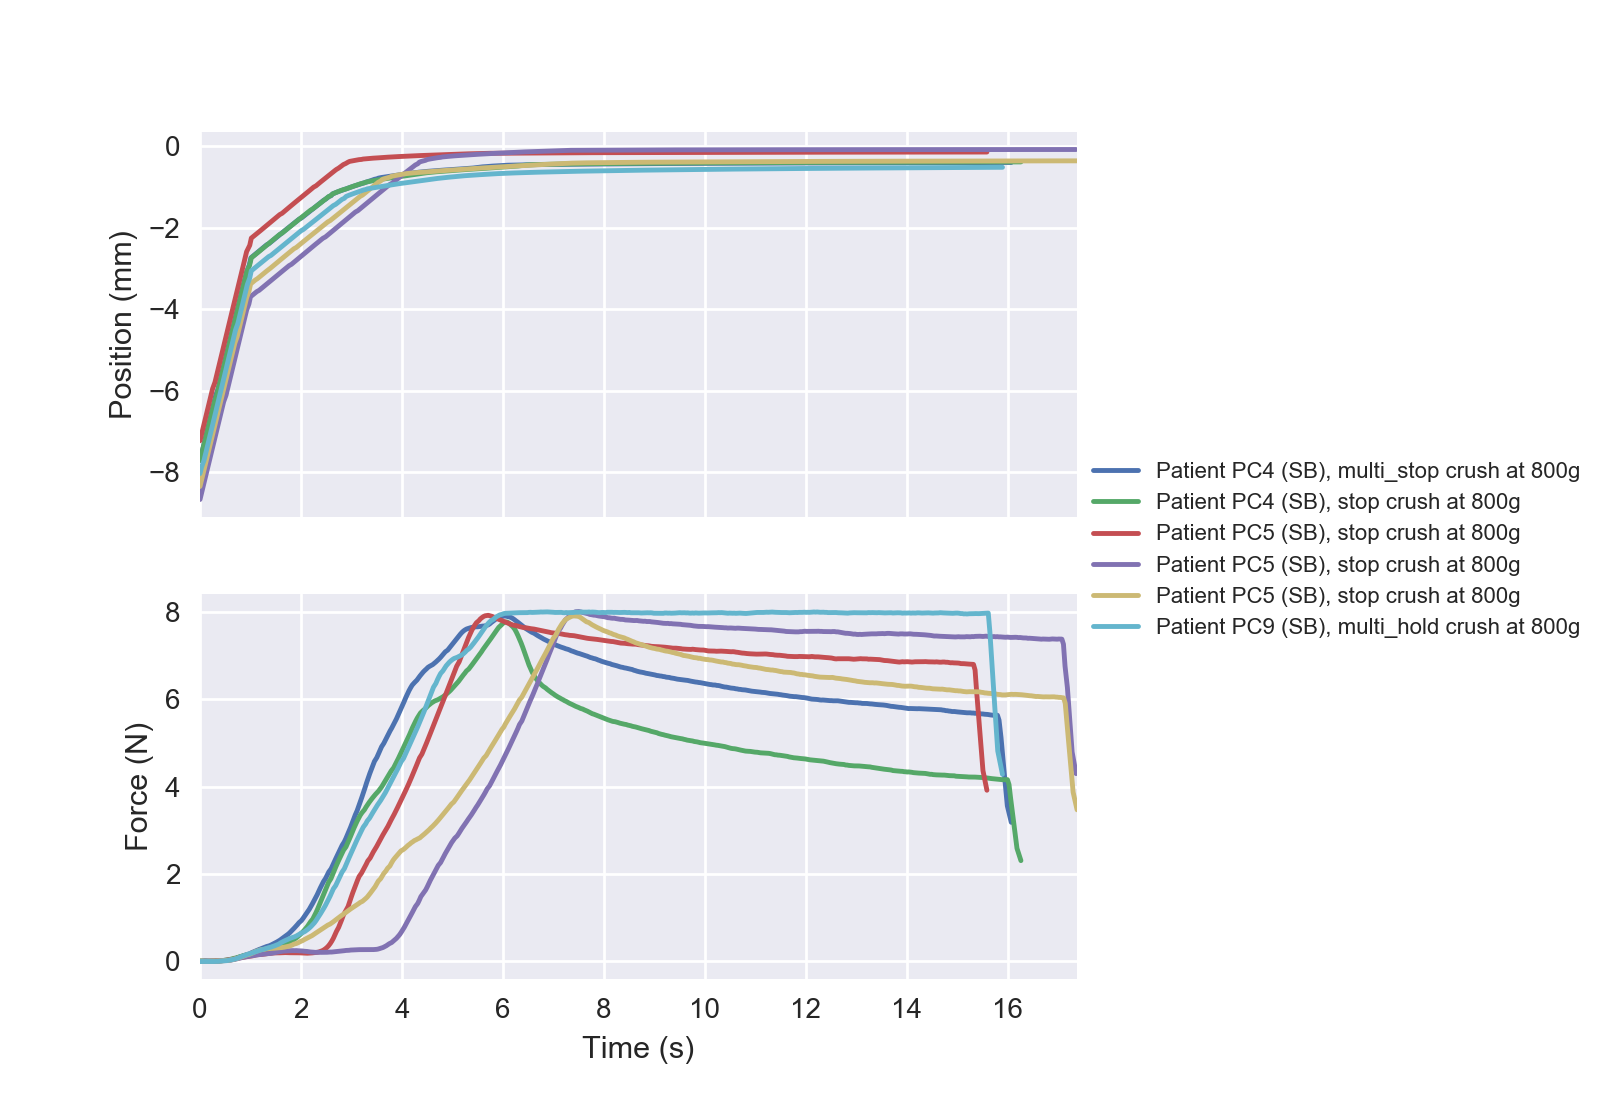

In [28]:
time_plot(select(tissue='sb', load='800g'))